In [110]:
import glob
import nibabel
import numpy as np
import re
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
import os
import cc3d
import shutil
from collections import defaultdict
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from utils import show_slices, check_patch, get_symmetric_value

from skimage.feature import hog
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import data, exposure
import scipy.ndimage as ndi

import ipyvolume as ipv

from warnings import filterwarnings 
filterwarnings(action='ignore')

In [38]:
N = image.shape[1]
image = data.astronaut()
image_blurred = ndi.uniform_filter(image, size=32)
image_half = np.concatenate([image[:,:N//2:,:], image_blurred[:,N//2:,:]],1)

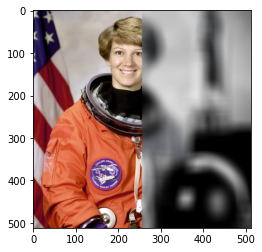

In [39]:
plt.imshow(image_half)

In [114]:
def HOG2DEntropy(image):
    
    fd, hog_image = hog(image/image.max(), orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(3, 3), visualize=True, multichannel=len(image.shape)>2)
    
#     hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    entr_img = entropy(hog_image.astype(int), disk(10))
    
    return hog_image, entr_img
    


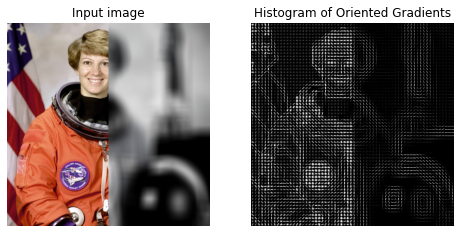

In [51]:

fd, hog_image = hog(image_half, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_half, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [52]:
hog_image.shape

(512, 512)

In [53]:
entr_img = entropy(hog_image.astype(int), disk(10))

/media/tom/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return _convert(image, np.uint8, force_copy)


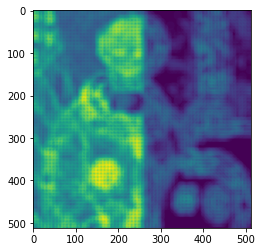

In [54]:
plt.imshow(entr_img)

In [55]:

paths_dict = defaultdict(dict)
for p in os.listdir('../fcd_data/normalized_label'):
    
    label = p.split('.')[0]
    
    sub_root = f'../fcd_data/normalized_data/sub-{label}/anat/'
    brain_path = glob.glob(os.path.join(sub_root, '*Asym_desc-preproc_T1w.nii.gz'))[0]
    mask_path = glob.glob(os.path.join(sub_root, '*Asym_desc-brain_mask.nii.gz'))[0]
    label_path = f'../fcd_data/normalized_label/{p}'
    
    # features
    thickness_path = f'../fcd_data/preprocessed_data_anadezhda/thickness/norm-{label}.nii'
    sulc_path = f'../fcd_data/preprocessed_data_anadezhda/sulc/norm-{label}.nii'
    curv_path = f'../fcd_data/preprocessed_data_anadezhda/curv/norm-{label}.nii'
    
    paths_dict[label]['label'] = label_path
    paths_dict[label]['brain'] = brain_path    
    paths_dict[label]['mask'] = mask_path  
    
    paths_dict[label]['thickness'] = thickness_path
    paths_dict[label]['sulc'] = sulc_path    
    paths_dict[label]['curv'] = curv_path    

In [68]:
for label, path_dict in paths_dict.items():
    
    mask_tensor = nibabel.load(path_dict['mask']).get_fdata() > 0
    brain_tensor = nibabel.load(path_dict['brain']).get_fdata()
    brain_tensor = brain_tensor*mask_tensor.astype(int)
    label_tensor = nibabel.load(path_dict['label']).get_fdata()
    
    if label_tensor[mask_tensor].sum() / np.prod(mask_tensor.shape) > 0.005:
    
        break

In [69]:
label_tensor.sum()

373.99867360536837

Exception ignored in: <function tqdm.__del__ at 0x7fb0d524bdc0>
Traceback (most recent call last):
  File "/media/tom/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/media/tom/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


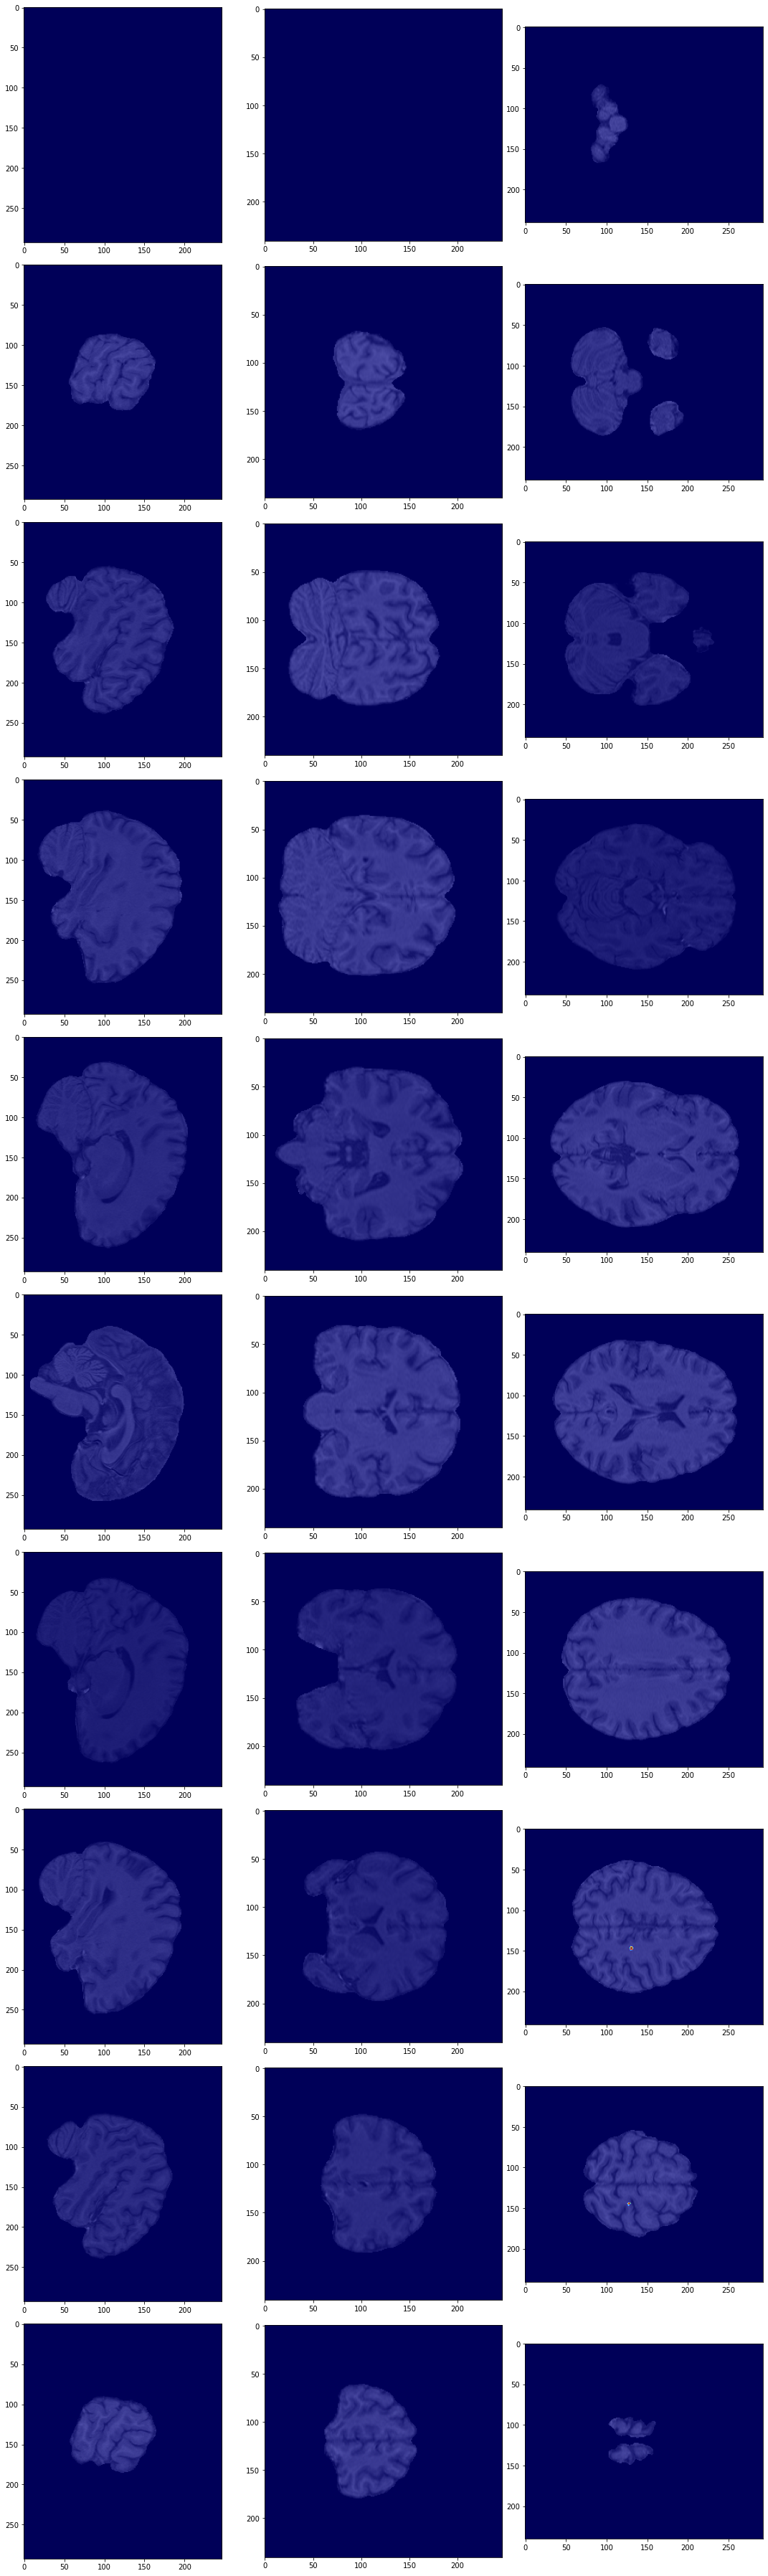

In [70]:
show_slices(brain_tensor, mask_tensor=label_tensor, n_slices_show=10)

# Patches dataset

In [73]:
USE_GEOM_FEATURES = True
GEOM_FEATURES = ['thickness', 'sulc', 'curv']
patch_size=64
padding_size=patch_size//2
patches_data_root = f'../fcd_data/patches_dataset_{patch_size}' + ('_features' if USE_GEOM_FEATURES else '')

metadata_train = pd.read_csv(os.path.join(patches_data_root,'metadata_train'))
metadata_test = pd.read_csv(os.path.join(patches_data_root,'metadata_test'))

In [74]:
metadata_train

,x,y,z,p_mask,p_label,label
0,203.0,234.0,103.0,0.553059,0.255737,38
1,192.0,223.0,110.0,0.562866,0.258121,38
2,89.0,206.0,135.0,0.835838,0.000000,13
3,199.0,219.0,103.0,0.568859,0.256435,38
4,105.0,113.0,155.0,0.547325,0.000000,16
...,...,...,...,...,...,...
8296,204.0,233.0,102.0,0.551178,0.258461,38
8297,208.0,222.0,110.0,0.669800,0.257591,38
8298,208.0,220.0,100.0,0.569290,0.255260,38
8299,202.0,138.0,170.0,0.678677,0.000000,9


In [75]:
N_train, N_test = metadata_train.shape[0], metadata_test.shape[0]
train_label_mask = metadata_train['p_label'] > 0
metadata_train_label = metadata_train[train_label_mask]

In [76]:
for index in np.random.choice(np.arange(metadata_train_label.shape[0]), size=9):
    metaindex = metadata_train_label.iloc[index]
    tensor = torch.load(os.path.join(patches_data_root, f'tensor_{metaindex.label}'))
    x,y,z = metaindex[['x','y','z']].astype(int)
    
    x1,x2 = x-patch_size//2, x+patch_size//2
    y1,y2 = y-patch_size//2, y+patch_size//2
    z1,z2 = z-patch_size//2, z+patch_size//2
    
    brain_patch = tensor[0,x1:x2,y1:y2,z1:z2].numpy()
    label_patch = tensor[-1,x1:x2,y1:y2,z1:z2].numpy()
    
    break

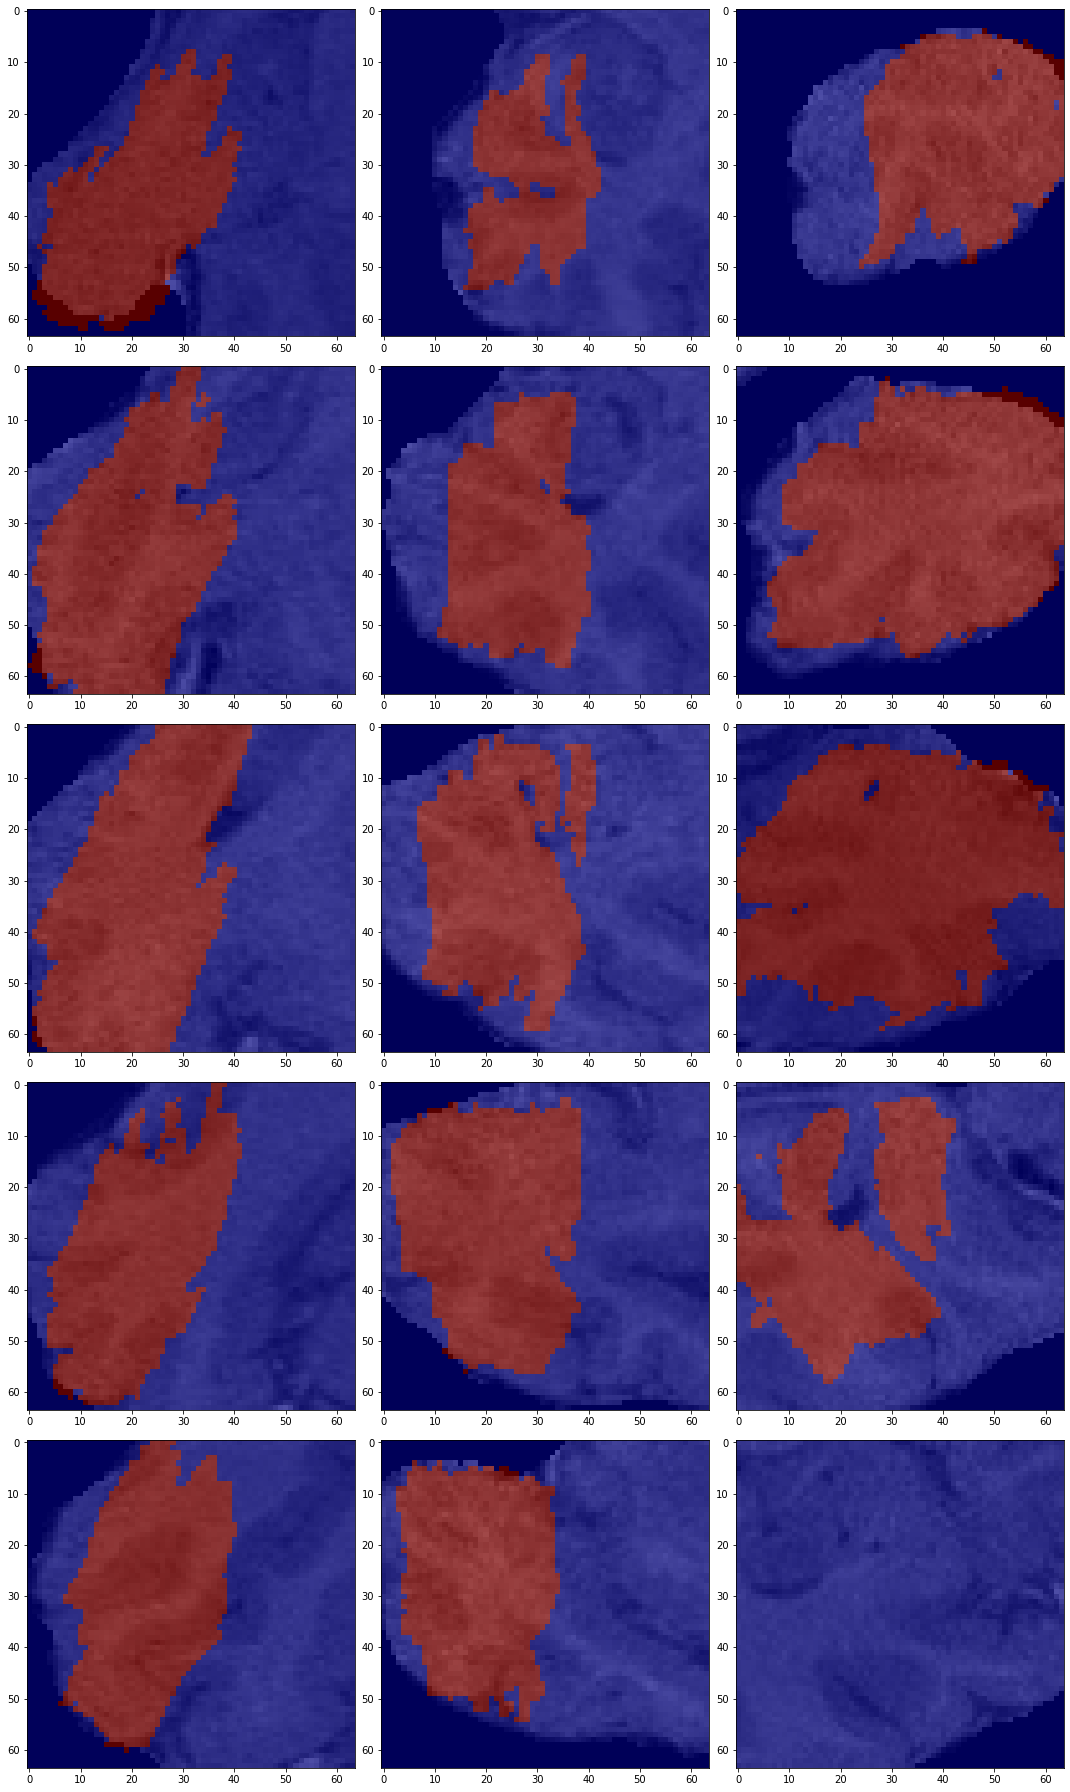

In [77]:
show_slices(brain_patch, mask_tensor=label_patch)

/tmp/ipykernel_15346/1418917173.py:15: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_tensor_x_slice = HOG2DEntropy(brain_tensor_x_slice)
/tmp/ipykernel_15346/1418917173.py:16: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_tensor_y_slice = HOG2DEntropy(brain_tensor_y_slice)
/media/tom/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 117 fits in uint8
  return _convert(image, np.uint8, force_copy)
/tmp/ipykernel_15346/1418917173.py:17: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence

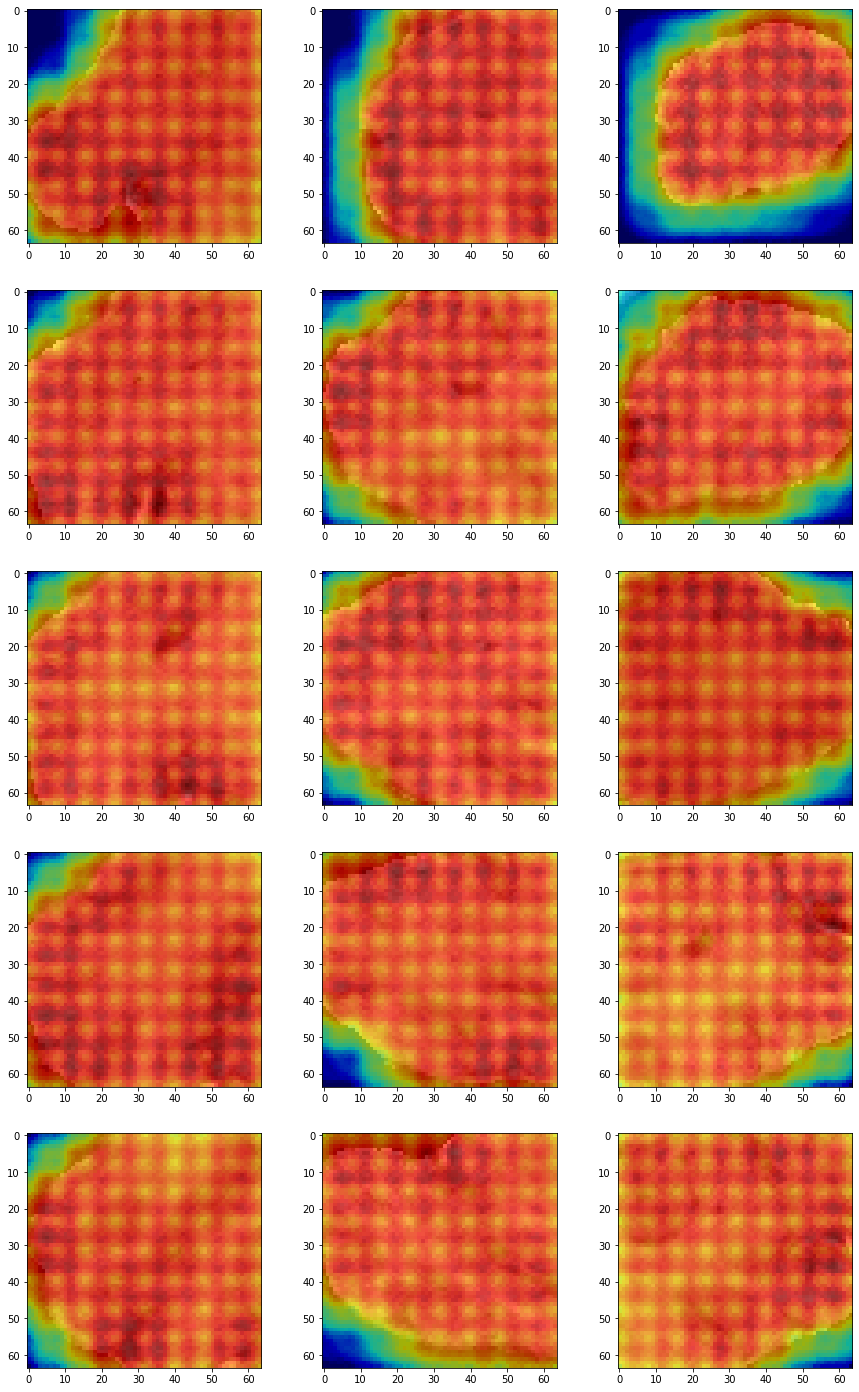

In [109]:
brain_tensor = brain_patch
n_slices_show = 5
fig, axes = plt.subplots(ncols=3, nrows=n_slices_show, figsize=(15,n_slices_show*5))
X_max, Y_max, Z_max = brain_tensor.shape
for i in range(n_slices_show):

    x_slice_pos = (X_max//(n_slices_show+2))*(i+1)
    y_slice_pos = (Y_max//(n_slices_show+2))*(i+1)
    z_slice_pos = (Z_max//(n_slices_show+2))*(i+1)

    brain_tensor_x_slice = brain_tensor[x_slice_pos,:,:]
    brain_tensor_y_slice = brain_tensor[:,y_slice_pos,:]
    brain_tensor_z_slice = brain_tensor[:,:,z_slice_pos]
    
    entropy_tensor_x_slice = HOG2DEntropy(brain_tensor_x_slice)
    entropy_tensor_y_slice = HOG2DEntropy(brain_tensor_y_slice)
    entropy_tensor_z_slice = HOG2DEntropy(brain_tensor_z_slice)

    axes[i,0].imshow(brain_tensor_x_slice, 'gray')
    axes[i,1].imshow(brain_tensor_y_slice, 'gray')
    axes[i,2].imshow(brain_tensor_z_slice, 'gray')

    if mask_tensor is not None:

        mask_tensor_x_slice = mask_tensor[x_slice_pos,:,:]
        mask_tensor_y_slice = mask_tensor[:,y_slice_pos,:]
        mask_tensor_z_slice = mask_tensor[:,:,z_slice_pos]

        axes[i,0].imshow(entropy_tensor_x_slice, 'jet', interpolation='none', alpha=0.7)
        axes[i,1].imshow(entropy_tensor_y_slice, 'jet', interpolation='none', alpha=0.7)
        axes[i,2].imshow(entropy_tensor_z_slice, 'jet', interpolation='none', alpha=0.7)

In [115]:
hog_image, entr_img = HOG2DEntropy(brain_tensor_x_slice)

In [157]:
fd, hog_image = hog(brain_tensor_x_slice/brain_tensor_x_slice.max(), 
                orientations=9, 
                pixels_per_cell=(4, 4),
                cells_per_block=(4, 4), 
                visualize=True, 
                feature_vector=False,
                multichannel=False)

In [ ]:
# 

In [161]:
fd[0,0].shape

(4, 4, 9)

In [162]:
from IPython.core.debugger import set_trace

In [170]:
# def square(i):
#     i_square = i**2
#     set_trace()
#     return i_square
    

# def foo(n):
#     for i in range(n):
#         x = square(i)
#         set_trace()
        
        

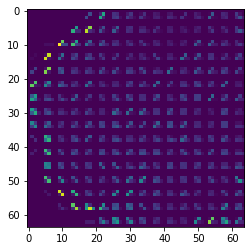

In [159]:
plt.imshow(hog_image)

In [139]:
# ipv.quickvolshow(label_patch, level=[0.01, 0.99], opacity=0.03, level_width=0.1, data_min=0, data_max=1)